In [1]:
import random
import os
import sys
import time
import numpy as np
import math

In [2]:
from CurveCGen import *
from CurveEA import *

In [3]:
import subprocess
BLENDER_PATH="C:\\Program Files\\Blender Foundation\\Blender 3.3\\blender.exe"

In [4]:
OUTPUT_PATH="E:\\Research\\Statue Generator\\Generations"

In [5]:
def shannon_entropy(file_path):
    with open(file_path, "rb") as f:
        bytes = f.read()
    prob = [float(bytes.count(b)) / len(bytes) for b in set(bytes)]
    entropy = -sum([p * math.log(p) / math.log(2.0) for p in prob])
    return round(entropy,6)

In [6]:
def calculate_angles(vertices, edges):
    angles = []
    for i, edge in enumerate(edges):
        v1, v2 = edge
        v3 = edges[(i + 1) % len(edges)][1]
        a = math.sqrt((vertices[v2][0] - vertices[v1][0]) ** 2 + (vertices[v2][1] - vertices[v1][1]) ** 2 + (vertices[v2][2] - vertices[v1][2]) ** 2)
        b = math.sqrt((vertices[v3][0] - vertices[v2][0]) ** 2 + (vertices[v3][1] - vertices[v2][1]) ** 2 + (vertices[v3][2] - vertices[v2][2]) ** 2)
        c = math.sqrt((vertices[v3][0] - vertices[v1][0]) ** 2 + (vertices[v3][1] - vertices[v1][1]) ** 2 + (vertices[v3][2] - vertices[v1][2]) ** 2)
        if a==0:
            print("a")
        if b==0:
            print("b")
        if c==0:
            print("c")
        angle = math.acos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
        angles.append(math.degrees(angle))
    
    angle_bins = {f"{i}-{i+5}": 0 for i in range(0, 356, 5)}
    for angle in angles:
        bin_number = int(angle // 5) * 5
        angle_bins[f"{bin_number}-{bin_number+5}"] = 1
    
    score=0
    for b in angle_bins:
        score+=angle_bins[b]
    
    return round(score/72,6),angle_bins


In [7]:
def gen_blender(ARR,GEN_NUM):
    
    os.mkdir(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))
    
    for i,C in enumerate(ARR):
        
        #[r,g,b,a,bd,me,ro,ss,[VERTICES,EDGES],[new_L,new_B,new_H]]

        VERTS=C[8][0]
        EDGES=C[8][1]
        MATERIAL=str([C[0],C[1],C[2],C[3]])
        BD=str(C[4])
        ME=str(C[5])
        RO=str(C[6])
        SS=str(C[7])
        FILE_NUM=str(i)
        
        with open(f'{OUTPUT_PATH}\\GEN_{GEN_NUM}\\VERTS_G{GEN_NUM}_S{i}.txt', 'w') as f:
            f.writelines(str(VERTS))

        subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G{GEN_NUM}_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))],capture_output=True,shell=True)
        #time.sleep(60)
        
        #print(f'Statue {i} Saved!')

## Basic Parameters for generation

In [8]:
L,B,H=10,12,17
POPULATION_SIZE=10

In [9]:
PARAMS=[]

## Initial Population

In [10]:
%%time

INITIAL_POPULATION=[]

for _ in range(POPULATION_SIZE):
    CH=generate_chromosome(L,B,H)
    INITIAL_POPULATION.append(CH)
    get_stats(CH)
    print('-'*125)

PARAMS.append(INITIAL_POPULATION)

(R, G, B, A) = (0.814524, 0.086888, 0.701634, 0.711999)
Number of vertices = 7
Number of edges = 6
Bevel Depth = 1.35
Metallic = 0.230927
Roughness = 0.293076
Subsurface Level = 0
New Bounding Box - (L,B,H) = (4.62191,4.93156,11.5272)
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.339813, 0.00268, 0.10252, 0.731183)
Number of vertices = 4
Number of edges = 3
Bevel Depth = 0.4
Metallic = 0.597538
Roughness = 0.069651
Subsurface Level = 3
New Bounding Box - (L,B,H) = (4.927297,6.265723,7.008318)
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.267629, 0.745427, 0.132264, 0.768542)
Number of vertices = 8
Number of edges = 7
Bevel Depth = 0.75
Metallic = 0.148804
Roughness = 0.448198
Subsurface Level = 2
New Bounding Box - (L,B,H) = (3.780504,9.853111,5.459759)
----------------------------------------

In [11]:
%%time

os.mkdir(OUTPUT_PATH+"\\GEN_0")

for i,C in enumerate(PARAMS[0]):

    VERTS=C[8][0]
    EDGES=C[8][1]
    MATERIAL=str([C[0],C[1],C[2],C[3]])
    BD=str(C[4])
    ME=str(C[5])
    RO=str(C[6])
    SS=str(C[7])
    FILE_NUM=str(i)
    
    with open(f'{OUTPUT_PATH}\\GEN_0\\VERTS_G{0}_S{i}.txt', 'w') as f:
        f.writelines(str(VERTS))

    #subprocess.run(["blender", "--background", "--python","convexGeneratePopulation.py",FILE_NUM,f'VERTS_G{GEN_NUM}_S{i}.txt',f'FACES_G{GEN_NUM}_S{i}.txt',f'MATERIALS_G{GEN_NUM}_S{i}.txt',str(RO),str(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))],capture_output=True,shell=True)
    subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G0_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True)
    #subprocess.run(["blender", "--background", "--python","convexGeneratePopulation.py",FILE_NUM,f'VERTS_G{0}_S{i}.txt',f'FACES_G{0}_S{i}.txt',f'MATERIALS_G{0}_S{i}.txt',str(RO),str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True)
    #print(subprocess.run(["blender", "--background", "--python","generatePopulation.py",FILE_NUM,COLOUR,f'VERTS_G{0}_S{i}.txt',f'FACES_G{0}_S{i}.txt',str(RO),str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True))
    #time.sleep(60)
    
    print(f'Statue {i} Saved!')
    

Statue 0 Saved!
Statue 1 Saved!
Statue 2 Saved!
Statue 3 Saved!
Statue 4 Saved!
Statue 5 Saved!
Statue 6 Saved!
Statue 7 Saved!
Statue 8 Saved!
Statue 9 Saved!
Wall time: 45.2 s


## Crossover and Mutation for more generations

In [12]:
GENERATIONS=300

In [13]:
%%time

ALL_FITNESS=[]
BEST_FITNESS=[]
GEN_NUM=1

for _ in range(GENERATIONS):
    
    PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GEN_NUM-1)
    FITNESS=[]
    
    for i in range(POPULATION_SIZE):
        
        VERTS=PARAMS[GEN_NUM-1][i][8][0]
        EDGES=PARAMS[GEN_NUM-1][i][8][1]
        
        #angle,angle_bins=calculate_angles(VERTS,EDGES)
        
        entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
        entropy=entropy/8 
        
        fitness=entropy
        FITNESS.append(round(fitness,6))
    
    ALL_FITNESS.append(FITNESS)
    
    BEST_FITNESS.append(FITNESS.index(max(FITNESS)))
    print(f'Statue-{FITNESS.index(max(FITNESS))} has the best fitness value in {GEN_NUM-1} generation.')
    
    MODELS=[]
    
    for _ in range(int(POPULATION_SIZE/2)):
    
        #selecting 2 random parents from previous generation
        idx1,idx2=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p1=idx1 if FITNESS[idx1]>FITNESS[idx2] else idx2
        
        idx3,idx4=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p2=idx3 if FITNESS[idx3]>FITNESS[idx4] else idx4
        
        #perform crossover for the selected parents
        c1,c2=crossover(PARAMS[GEN_NUM-1][p1],PARAMS[GEN_NUM-1][p2])
        
        #mutate the children after crossover
        m1=mutate(c1,L,B,H)
        m2=mutate(c2,L,B,H)
        
        MODELS.append(m1)
        MODELS.append(m2)
        
    #print(len(MODELS))
    #appending the mutated childs to PARAMS array
    PARAMS.append(MODELS)
    
    #generate blender file
    gen_blender(MODELS,GEN_NUM)
    
    print(f"Generation {GEN_NUM} generated successfully!")
    print("-"*120)
    
    GEN_NUM+=1

Statue-6 has the best fitness value in 0 generation.
Generation 1 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 1 generation.
Generation 2 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 2 generation.
Generation 3 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-6 has the best fitness value in 3 generation.
Generation 4 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-8 has the best fitness value in 4 generation.
Generation 5 generated successfully!
------------------------------------------------------------------

Statue-0 has the best fitness value in 39 generation.
Generation 40 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-9 has the best fitness value in 40 generation.
Generation 41 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-1 has the best fitness value in 41 generation.
Generation 42 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-7 has the best fitness value in 42 generation.
Generation 43 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-9 has the best fitness value in 43 generation.
Generation 44 generated successfully!
--------------------------------------------------------

Statue-4 has the best fitness value in 78 generation.
Generation 79 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-2 has the best fitness value in 79 generation.
Generation 80 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-7 has the best fitness value in 80 generation.
Generation 81 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-3 has the best fitness value in 81 generation.
Generation 82 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-1 has the best fitness value in 82 generation.
Generation 83 generated successfully!
--------------------------------------------------------

Statue-7 has the best fitness value in 117 generation.
Generation 118 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-8 has the best fitness value in 118 generation.
Generation 119 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 119 generation.
Generation 120 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-4 has the best fitness value in 120 generation.
Generation 121 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 121 generation.
Generation 122 generated successfully!
----------------------------------------------

Generation 156 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 156 generation.
Generation 157 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-3 has the best fitness value in 157 generation.
Generation 158 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-9 has the best fitness value in 158 generation.
Generation 159 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-4 has the best fitness value in 159 generation.
Generation 160 generated successfully!
-----------------------------------------------------------------------------------------------------

Statue-8 has the best fitness value in 194 generation.
Generation 195 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-9 has the best fitness value in 195 generation.
Generation 196 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-1 has the best fitness value in 196 generation.
Generation 197 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-2 has the best fitness value in 197 generation.
Generation 198 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-8 has the best fitness value in 198 generation.
Generation 199 generated successfully!
----------------------------------------------

Generation 233 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-7 has the best fitness value in 233 generation.
Generation 234 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-5 has the best fitness value in 234 generation.
Generation 235 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-1 has the best fitness value in 235 generation.
Generation 236 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-3 has the best fitness value in 236 generation.
Generation 237 generated successfully!
-----------------------------------------------------------------------------------------------------

Statue-1 has the best fitness value in 271 generation.
Generation 272 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-8 has the best fitness value in 272 generation.
Generation 273 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-0 has the best fitness value in 273 generation.
Generation 274 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-8 has the best fitness value in 274 generation.
Generation 275 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Statue-7 has the best fitness value in 275 generation.
Generation 276 generated successfully!
----------------------------------------------

In [14]:
%%time
PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GENERATIONS)
FINAL_FITNESS=[]

for i in range(POPULATION_SIZE):

    entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
    entropy=entropy/8

#     VERTS=PARAMS[GEN_NUM-1][i][8][0]
#     EDGES=PARAMS[GEN_NUM-1][i][8][1]

#     angle=calculate_angles(VERTS,EDGES)

    FINAL_FITNESS.append(round(entropy,6))

Wall time: 5.05 s


In [15]:
FINAL_FITNESS

[0.326254,
 0.32602,
 0.327383,
 0.326246,
 0.327208,
 0.325649,
 0.326701,
 0.327949,
 0.328132,
 0.328026]

In [16]:
ALL_FITNESS.append(FINAL_FITNESS)

In [17]:
FINAL_FITNESS.index(max(FINAL_FITNESS))

8

## Plot fitness

In [18]:
import matplotlib.pyplot as plt
def plot_fitness(fitness):
    
    best_values=[]
    for g in fitness:
        best_values.append(max(g))
    
    plt.figure(figsize=(20,10))
    plt.plot(best_values)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()

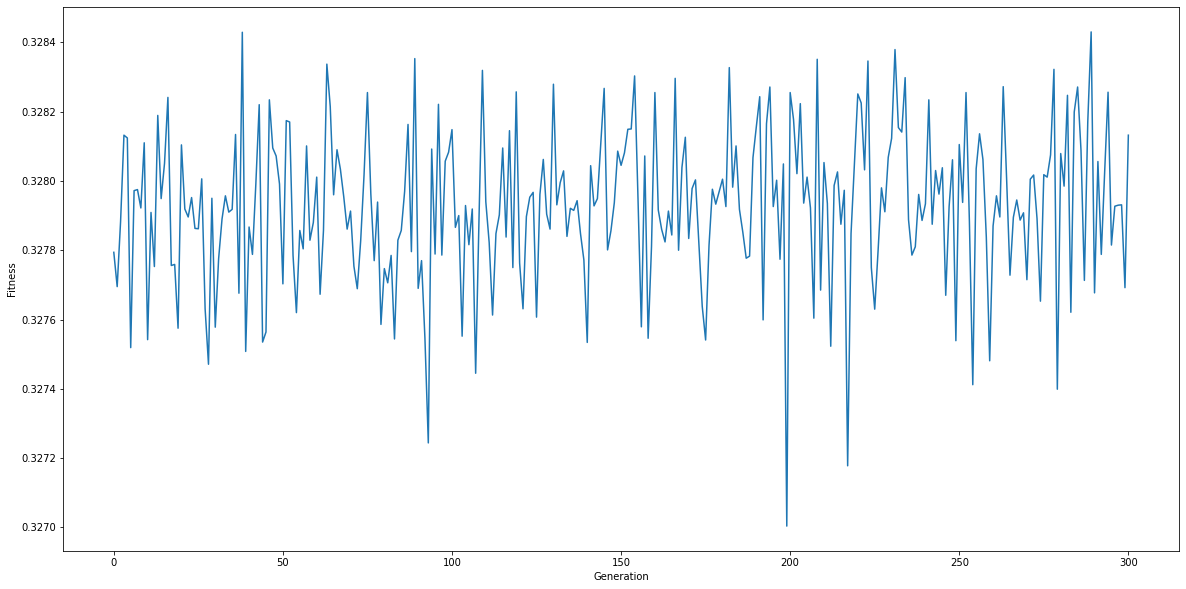

In [19]:
plot_fitness(ALL_FITNESS)

## Saving the parameters

In [20]:
with open(f'E:\Research\Statue gen output\\Curve_300Gen_3.txt', 'w') as f:
        f.writelines(str(PARAMS))